<a href="https://colab.research.google.com/github/laussin86/my-project/blob/main/Xgboost_model_for_house_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
import pandas as pd
import seaborn as sn
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,KFold 
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Load the data
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Jean-Marc Koffi-kouakou/1-28-23 redfin/houses.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Check the datatypes of the attributes.
print(df.dtypes)

url                object
price               int64
bed               float64
bath              float64
sqft              float64
address            object
city               object
type               object
year_built        float64
est_price           int64
price_per_sqft    float64
dtype: object


In [4]:
print(df.shape)
display(df.head())

(239, 11)


,url,price,bed,bath,sqft,address,city,type,year_built,est_price,price_per_sqft
0,https://www.redfin.com/OR/Portland/6725-SE-Hen...,369000,2.0,1.0,748.0,"6725 SE Henry St,","Portland, OR 97206",Single Family Residential,1951.0,370963,493.0
1,https://www.redfin.com/OR/Portland/2234-SE-30t...,716000,3.0,1.5,2451.0,"2234 SE 30th Ave,","Portland, OR 97214",Single Family Residential,1889.0,706940,292.0
2,https://www.redfin.com/OR/Portland/12332-SW-57...,560000,3.0,2.0,1909.0,"12332 SW 57th Ave,","Portland, OR 97219",Single Family Residential,1986.0,573623,293.0
3,https://www.redfin.com/OR/Portland/5304-SE-Ogd...,513000,2.0,1.0,1707.0,"5304 SE Ogden St,","Portland, OR 97206",Single Family Residential,1925.0,493870,301.0
4,https://www.redfin.com/OR/Portland/5395-SW-Dov...,950000,5.0,3.0,2876.0,"5395 SW Dover Ln,","Portland, OR 97225",Single Family Residential,1956.0,900768,330.0


# Preprocessing and EDA

In [5]:
# extract zipcode from city
df['Zip Code'] = df['city'].str.extract(r'(\d{5})')
display(df.head())

,url,price,bed,bath,sqft,address,city,type,year_built,est_price,price_per_sqft,Zip Code
0,https://www.redfin.com/OR/Portland/6725-SE-Hen...,369000,2.0,1.0,748.0,"6725 SE Henry St,","Portland, OR 97206",Single Family Residential,1951.0,370963,493.0,97206
1,https://www.redfin.com/OR/Portland/2234-SE-30t...,716000,3.0,1.5,2451.0,"2234 SE 30th Ave,","Portland, OR 97214",Single Family Residential,1889.0,706940,292.0,97214
2,https://www.redfin.com/OR/Portland/12332-SW-57...,560000,3.0,2.0,1909.0,"12332 SW 57th Ave,","Portland, OR 97219",Single Family Residential,1986.0,573623,293.0,97219
3,https://www.redfin.com/OR/Portland/5304-SE-Ogd...,513000,2.0,1.0,1707.0,"5304 SE Ogden St,","Portland, OR 97206",Single Family Residential,1925.0,493870,301.0,97206
4,https://www.redfin.com/OR/Portland/5395-SW-Dov...,950000,5.0,3.0,2876.0,"5395 SW Dover Ln,","Portland, OR 97225",Single Family Residential,1956.0,900768,330.0,97225


In [6]:
print(df.dtypes)

url                object
price               int64
bed               float64
bath              float64
sqft              float64
address            object
city               object
type               object
year_built        float64
est_price           int64
price_per_sqft    float64
Zip Code           object
dtype: object


In [7]:
# Are there any missing values in the dataset?
df.isnull().sum()

url               0
price             0
bed               2
bath              2
sqft              1
address           0
city              0
type              0
year_built        2
est_price         0
price_per_sqft    3
Zip Code          0
dtype: int64

In [8]:
#filling out missing value
df['year_built'].fillna(df.year_built.median(),inplace=True)
df['sqft'].fillna(df.sqft.median(),inplace=True)
df['bath'].fillna(df.bath.median(),inplace=True)
df['bed'].fillna(df.bed.median(),inplace=True)
df['price_per_sqft'].fillna(df.price_per_sqft.median(),inplace=True)

In [9]:
df.isnull().sum()

url               0
price             0
bed               0
bath              0
sqft              0
address           0
city              0
type              0
year_built        0
est_price         0
price_per_sqft    0
Zip Code          0
dtype: int64

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,239.0,613410.648536,373530.272976,79985.0,418440.0,535000.0,700125.0,3577600.0
bed,239.0,3.167364,1.015232,1.0,3.0,3.0,4.0,6.0
bath,239.0,2.035565,0.796388,0.5,1.0,2.0,2.5,4.5
sqft,239.0,2029.523013,1033.861525,510.0,1346.0,1875.0,2473.5,9900.0
year_built,239.0,1962.510460,35.574028,1888.0,1929.5,1960.0,1995.0,2023.0
est_price,239.0,605829.983264,361201.470817,94599.0,416389.0,531521.0,688220.5,3517359.0
price_per_sqft,239.0,314.292887,91.890268,60.0,258.0,307.0,361.5,724.0


With the description, we can observe that the average sold price of the 

house is around $613,411 while the estimated price in average for the 

houses was $605,830.

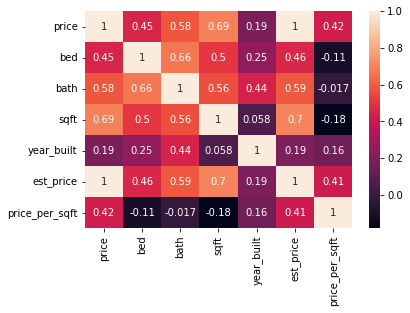

In [11]:
# correlation matrix
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

<Axes: >

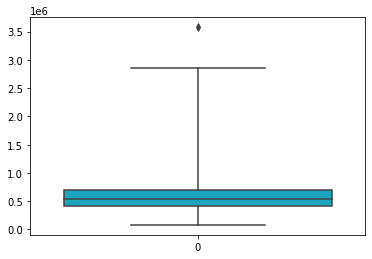

In [12]:
# Target Variable Distribution
sns.boxplot(df['price'], whis=10, color="#00B8D9")

We can notice a price outlier around $ 3.5 millions

<ipython-input-13-17ff67ae30f1>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'], kde=False,


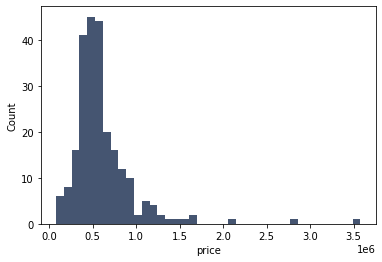

In [13]:
sns.distplot(df['price'], kde=False, 
             color="#172B4D", hist_kws={"alpha": 0.8});
plt.ylabel("Count");

With the histogram we can see that it is skewed on the right and there is 

between 2 millions and $3.6 millions.

noted as well that most of the houses sold are between around 200,000 and 900,000 dollars

<ipython-input-14-21ddc39115ff>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['sqft'], kde=False,


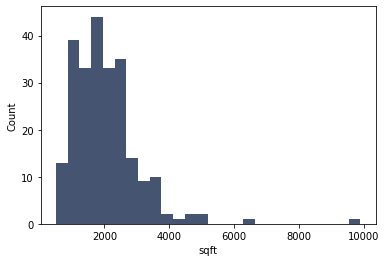

In [14]:
# visualization of the highly correlated target variables to other variables
sns.distplot(df['sqft'], kde=False, 
             color="#172B4D", hist_kws={"alpha": 0.8});
plt.ylabel("Count");

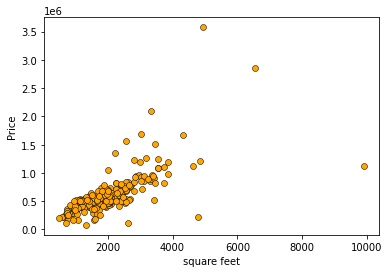

In [15]:
plt.scatter(x=df['sqft'], y=df['price'], 
            color="orange", edgecolors="#000000", linewidths=0.5);
plt.xlabel("square feet"); plt.ylabel("Price");

<ipython-input-16-7f9fa623d508>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['bath'], kde=False,


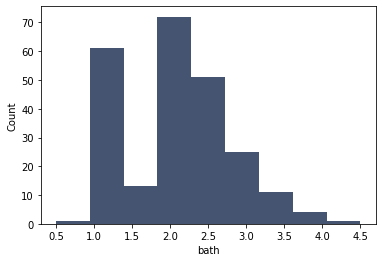

In [16]:
sns.distplot(df['bath'], kde=False, 
             color="#172B4D", hist_kws={"alpha": 0.8});
plt.ylabel("Count");

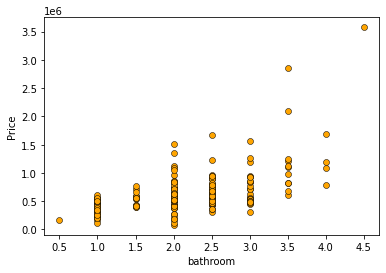

In [17]:
plt.scatter(x=df['bath'], y=df['price'], 
            color="orange", edgecolors="#000000", linewidths=0.5);
plt.xlabel("bathroom"); plt.ylabel("Price");

We can see that they are truly positively correlated; generally, as the overall bathroom increases, the sale price increases slightly too. This verfies what we got from the heatmap above.

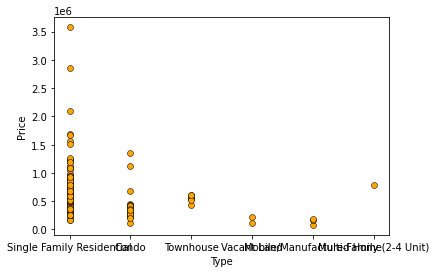

In [18]:
plt.scatter(x=df['type'], y=df['price'], 
            color="orange", edgecolors="#000000", linewidths=0.5);
plt.xlabel("Type"); plt.ylabel("Price");

With this scatterplot, we can see the majority of house sold was single family residence.

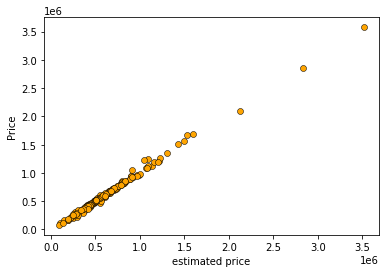

In [19]:
plt.scatter(x=df['est_price'], y=df['price'], 
            color="orange", edgecolors="#000000", linewidths=0.5);
plt.xlabel("estimated price"); plt.ylabel("Price");

of course the estimated price is almost the same as the sold price as we said earlier there is around 7,000 dolars difference between sold price and estimate price in average.

In [20]:
# unique value checking

df['address'].describe()

count                     239
unique                    237
top       3962 N Montana Ave,
freq                        2
Name: address, dtype: object

In [21]:
#too many unique value so it is better to drop it
df= df.drop('address', axis=1)

In [22]:
df['city'].describe()

count                    239
unique                    36
top       Portland, OR 97229
freq                      26
Name: city, dtype: object

In [23]:
df['Zip Code'].describe()

count       239
unique       33
top       97229
freq         26
Name: Zip Code, dtype: object

In [24]:
df['url'].describe()

count                                                   239
unique                                                  237
top       https://www.redfin.com/OR/Portland/3962-N-Mont...
freq                                                      2
Name: url, dtype: object

In [25]:
#too many unique value and not useful so it is better to drop it
df= df.drop('url', axis=1)

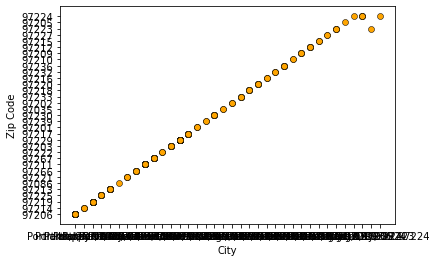

In [26]:
plt.scatter(x=df['city'], y=df['Zip Code'], 
            color="orange", edgecolors="#000000", linewidths=0.5);
plt.xlabel("City"); plt.ylabel("Zip Code");

In [27]:
# Zip code and city are higly correlated so i will keep the zip code. 

df= df.drop('city', axis=1)

In [28]:
df['type'].describe()

count                           239
unique                            6
top       Single Family Residential
freq                            204
Name: type, dtype: object

In [29]:
display(df.head())

,price,bed,bath,sqft,type,year_built,est_price,price_per_sqft,Zip Code
0,369000,2.0,1.0,748.0,Single Family Residential,1951.0,370963,493.0,97206
1,716000,3.0,1.5,2451.0,Single Family Residential,1889.0,706940,292.0,97214
2,560000,3.0,2.0,1909.0,Single Family Residential,1986.0,573623,293.0,97219
3,513000,2.0,1.0,1707.0,Single Family Residential,1925.0,493870,301.0,97206
4,950000,5.0,3.0,2876.0,Single Family Residential,1956.0,900768,330.0,97225


In [30]:
# need only the price 
df1=df.drop('est_price', axis=1)

In [31]:
#one hot-encoding
df1 = pd.get_dummies(df1)

In [32]:
display(df1.head())

,price,bed,bath,sqft,year_built,price_per_sqft,type_Condo,type_Mobile/Manufactured Home,type_Multi-Family (2-4 Unit),type_Single Family Residential,...,Zip Code_97225,Zip Code_97227,Zip Code_97229,Zip Code_97230,Zip Code_97232,Zip Code_97233,Zip Code_97236,Zip Code_97239,Zip Code_97266,Zip Code_97267
0,369000,2.0,1.0,748.0,1951.0,493.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,716000,3.0,1.5,2451.0,1889.0,292.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,560000,3.0,2.0,1909.0,1986.0,293.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,513000,2.0,1.0,1707.0,1925.0,301.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,950000,5.0,3.0,2876.0,1956.0,330.0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


# Model Building and Evaluation

In [33]:
df1.dtypes.value_counts()

uint8      39
float64     5
int64       1
dtype: int64

In [34]:
# lets first check the final dimension of our dataset after the preprocessing step
df1.shape

(239, 45)

In [35]:
scaler = StandardScaler()
# We need to fit the scaler to our data before transformation
df1.loc[:, df1.columns != 'price'] = scaler.fit_transform(df1.loc[:, df1.columns != 'price'])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    df1.drop('price', axis=1), df1[['price']], 
    test_size=0.25, random_state=3)


We will use GridSearchCV() to search for the best model parameters in a parameter space provided by us. 
 - The parameter "max_depth" sets the maximum depth of a tree, 
 
 -  "learning_rate" represents the step size shrinkage used in updating weights,
 
 - "n_estimators" specifies the number of boosted trees to fit,
 
 - "booster" determines which booster to use, 
 - "gamma" specifies the minimum loss reduction required to make a further partition on a leaf node of the tree, 
 - "subsample" is subsample ratio of the training instances; this subsampling will occur once in every boosting iteration, 
 - "colsample_bytree" specifies the subsample ratio of columns when constructing each tree, 
 - "colsample_bylevel" specifies the subsample ratio of columns for each split, in each level, 
 - "reg_alpha" is L1 regularization term, and 
 - "reg_lambda" is L2 regularization term.
 

In [38]:
parameter_space = \
    {
        "max_depth": [4, 5, 6],
        "learning_rate": [0.005, 0.009, 0.01],
        "n_estimators": [700, 1000, 2500],
        "booster": ["gbtree",],
        "gamma": [7, 25, 100],
        "subsample": [0.3, 0.6],
        "colsample_bytree": [0.5, 0.7],
        "colsample_bylevel": [0.5, 0.7,],
        "reg_alpha": [1, 10, 33],
        "reg_lambda": [1, 3, 10],
    }

clf = RandomizedSearchCV(XGBRegressor(random_state=3), 
                         parameter_space, cv=5, n_jobs=4,
                         scoring="neg_mean_absolute_error", 
                         random_state=3, n_iter=10)

clf.fit(X_train, y_train)
print("Best parameters:")
print(clf.best_params_)

Best parameters:
{'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 10, 'n_estimators': 2500, 'max_depth': 4, 'learning_rate': 0.009, 'gamma': 7, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'booster': 'gbtree'}


In [40]:
model = XGBRegressor(**clf.best_params_)

In [41]:
model.fit(X_train, y_train);

In [43]:
y_pred = model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, y_pred)
print("XGBoost MAE =", xgb_mae)

XGBoost MAE = 61050.72213541667


We chose the mean absolute error (MAE) as our performance metric to evaluate and compare models. MAE presents a value that is easy to understand; it shows the average value of model error. For example, for our XGBoost model, its MAE is 61,050.72 which means that on average, XGBoost will predict a value that is bigger or smaller than the true value by 61,050.72. Now to understand how good this MAE is, we need to know the range and distribution of the data. In our case, we need to see the values of the target variable price which contains the actual house prices.

In [47]:
y_train.describe(include=[np.number])

,price
count,1.790000e+02
mean,6.073578e+05
std,3.637366e+05
min,7.998500e+04
25%,4.159400e+05
50%,5.360000e+05
75%,6.965000e+05
max,3.577600e+06


We can see that the mean is 607,357.82 and the median is 536,000. We can see also that the first quartile is 415,940; this means that 75% of the data is larger than this number.Now looking at XGBoost error of 61,050.72, we can say that an error of about 61,000 is okay but still large for us for data whose mean is 607,357.82 and whose 75% of it is larger than 415,940. But will try to improved by constructing an neural network using the image house and those text data.

# Feature Importances

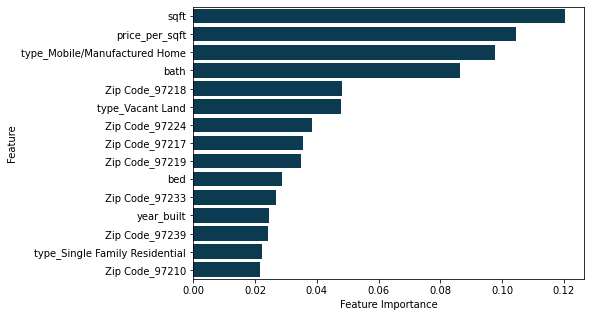

In [46]:

xgb_feature_importances = model.feature_importances_
xgb_feature_importances = pd.Series(
    xgb_feature_importances, index=X_train.columns.values
    ).sort_values(ascending=False).head(15)

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x=xgb_feature_importances, 
            y=xgb_feature_importances.index, 
            color="#003f5c");
plt.xlabel('Feature Importance');
plt.ylabel('Feature');

we can see that Squarefeet,price per squarefeet, type mobile/manufactured home and bath respectively were the most important features to predict the house price.